In [28]:
import pandas as pd
data = pd.read_csv('../data/raw/MachineLearningRating_v3.txt', sep='|', low_memory=False)

In [48]:
data.info()         # Data types, non-null counts
data.describe()     # Summary stats
data.head()         # First few rows
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 61 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   UnderwrittenCoverID       1000098 non-null  int64   
 1   PolicyID                  1000098 non-null  int64   
 2   TransactionMonth          1000098 non-null  category
 3   IsVATRegistered           1000098 non-null  bool    
 4   Citizenship               1000098 non-null  category
 5   LegalType                 1000098 non-null  category
 6   Title                     1000098 non-null  category
 7   Language                  1000098 non-null  category
 8   Bank                      1000098 non-null  category
 9   AccountType               1000098 non-null  category
 10  MaritalStatus             1000098 non-null  category
 11  Gender                    1000098 non-null  category
 12  Country                   1000098 non-null  category
 13  Province    

c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


(1000098, 61)

In [30]:
num_cols = data.select_dtypes(include=['float64','int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [31]:
cat_cols = data.select_dtypes(include=['object']).columns
data[cat_cols] = data[cat_cols].fillna('Unknown')

In [32]:
data = data.drop_duplicates()

In [33]:
data['TransactionMonth'] = pd.to_datetime(data['TransactionMonth'])
# Convert categorical columns
for col in cat_cols:
    data[col] = data[col].astype('category')

In [34]:
data['LossRatio'] = data['TotalClaims'] / data['TotalPremium']


In [35]:

data['HadClaim'] = (data['TotalClaims'] > 0).astype(int)
claim_counts = data.groupby(['PolicyID', 'UnderwrittenCoverID'])['HadClaim'].sum().reset_index(name='ClaimCount')
data = data.merge(claim_counts, on=['PolicyID', 'UnderwrittenCoverID'], how='left')
print(data[['PolicyID', 'UnderwrittenCoverID', 'TotalClaims', 'HadClaim', 'ClaimCount']].head())

   PolicyID  UnderwrittenCoverID  TotalClaims  HadClaim  ClaimCount
0     12827               145249          0.0         0           0
1     12827               145249          0.0         0           0
2     12827               145249          0.0         0           0
3     12827               145255          0.0         0           0
4     12827               145255          0.0         0           0


In [36]:
data['ClaimFrequency'] = data['ClaimCount'] / 1

In [37]:
# Create the LossRatio column
data['LossRatio'] = data['TotalClaims'] / data['TotalPremium']
data['Severity'] = data['TotalClaims'] / data['ClaimCount']
data['Severity'] = data['Severity'].fillna(0)
data['RiskScore'] = 0.3*data['LossRatio'] + 0.4*data['Severity'] + 0.3*data['ClaimFrequency']


In [38]:
data['HighRiskFlag'] = (data['RiskScore'] > data['RiskScore'].quantile(0.75)).astype(int)
data['ExpensiveVehicleFlag'] = (data['CustomValueEstimate'] > data['CustomValueEstimate'].median()).astype(int)
data['OldVehicleFlag'] = (2025 - data['RegistrationYear'] > 10).astype(int)


In [39]:
# One-hot encoding for modeling
data_encoded = pd.get_dummies(data, columns=['Province','Gender','VehicleType'], drop_first=True)


In [40]:
data[['LossRatio','ClaimFrequency','Severity','RiskScore']].describe()


c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,LossRatio,ClaimFrequency,Severity,RiskScore
count,618614.0,1.000098e+06,1.000098e+06,618614.0
mean,NaN,2.879918e-02,-inf,NaN
std,NaN,1.830718e-01,NaN,NaN
min,-inf,0.000000e+00,-inf,-inf
25%,0.0,0.000000e+00,0.000000e+00,0.0
50%,0.0,0.000000e+00,0.000000e+00,0.0
75%,0.0,0.000000e+00,0.000000e+00,0.0
max,inf,4.000000e+00,3.930921e+05,inf


In [41]:
from scipy.stats import ttest_ind

male = data[data['Gender']=='Male']['LossRatio']
female = data[data['Gender']=='Female']['LossRatio']

t_stat, p_val = ttest_ind(male, female, equal_var=False)
print(f"T-test: t={t_stat}, p={p_val}")


T-test: t=nan, p=nan


In [50]:
from scipy.stats import f_oneway

groups = [data[data['Province']==p]['Severity'] for p in data['Province'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: F={f_stat}, p={p_val}")
data.shape

ANOVA: F=nan, p=nan


c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\scipy\stats\_stats_py.py:3974: RuntimeWarning: invalid value encountered in subtract
  alldata = alldata - offset
c:\Users\a_kas\acis-insurance-risk-analytics\.venv\Lib\site-packages\scipy\stats\_stats_py.py:3982: RuntimeWarning: invalid value encountered in subtract
  smo_ss = _square_of_sums(sample - offset, axis=axis)


(1000098, 61)

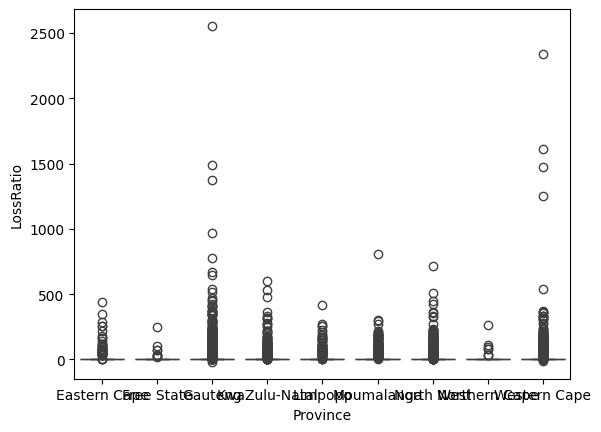

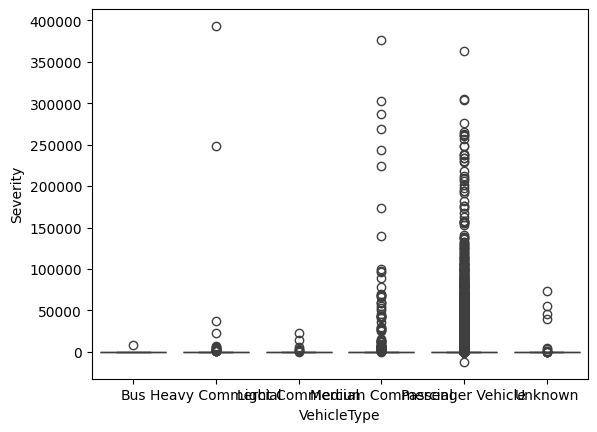

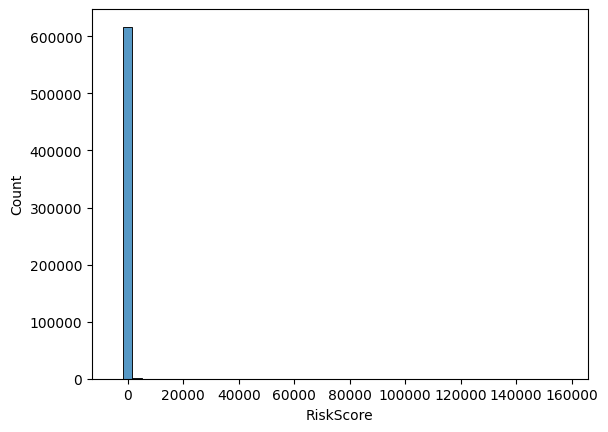

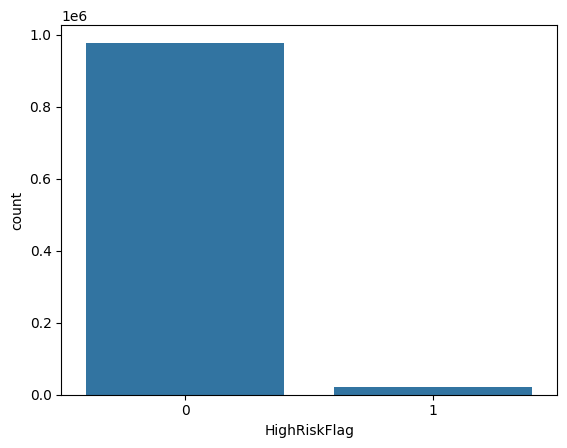

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Loss Ratio by Province
sns.boxplot(x='Province', y='LossRatio', data=data)
plt.show()

# 2. Severity by VehicleType
sns.boxplot(x='VehicleType', y='Severity', data=data)
plt.show()

# 3. RiskScore Distribution
sns.histplot(data['RiskScore'], bins=50)
plt.show()

# 4. HighRiskFlag counts
sns.countplot(x='HighRiskFlag', data=data)
plt.show()


In [47]:
data.to_csv("../data/clean/insurance_claims_cleaned.csv", index=False)
data_encoded.to_csv("../data/clean/insurance_claims_encoded.csv", index=False)
